## Importación

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTEN
from imblearn.over_sampling import RandomOverSampler

In [123]:
df=pd.read_csv("https://raw.githubusercontent.com/nathygonzalez/PR06-Machine-Learning-Group-Project/develop/data/df_cleaned.csv")

C:\Users\carlo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (99) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## depuración columna "gk"

In [124]:
df['gk'] =df['gk'].replace("+","")

In [125]:
df['gk'] = df['gk'].str.replace(r'\+', '', regex=True)


In [126]:
df.gk.fillna(0,inplace=True)

In [127]:
df['gk']=df.gk.astype(int)

In [128]:
df['gk']

0        15
1        16
2        14
3        17
4        87
         ..
87742     0
87743     0
87744     0
87745     0
87746     0
Name: gk, Length: 87747, dtype: int32

## Añadir variable años pendientes de contrato

In [129]:
df['años_de_contrato']=np.where((df['club_contract_valid_until']-df['año_version'])<0,0,(df['club_contract_valid_until']-df['año_version']))

In [130]:
#comprobación
df.groupby('años_de_contrato')['años_de_contrato'].count()

años_de_contrato
0.0    30707
1.0    21182
2.0    17779
3.0     9287
4.0     4872
5.0     2502
6.0     1413
7.0        3
8.0        2
Name: años_de_contrato, dtype: int64

## Eliminación de ruido

In [131]:
#elimino columnas (según Sergio)
'''df.drop(['sofifa_id',
 'short_name',
 'long_name',
 'player_positions',
     'dob', 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
'club_jersey_number',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id','work_rate',
 'body_type',
 'real_face',
    'player_traits'],axis=1,inplace=True)'''

"df.drop(['sofifa_id',\n 'short_name',\n 'long_name',\n 'player_positions',\n     'dob', 'club_team_id',\n 'club_name',\n 'league_name',\n 'league_level',\n'club_jersey_number',\n 'club_joined',\n 'club_contract_valid_until',\n 'nationality_id',\n 'nationality_name',\n 'nation_team_id','work_rate',\n 'body_type',\n 'real_face',\n    'player_traits'],axis=1,inplace=True)"

In [132]:
#eliminamos columnas que sabemos seguro que sólo aportan ruido (según Carlos)
df.drop(["sofifa_id",'short_name', 'long_name',"nationality_id","dob",'club_team_id', 'club_name', 'league_name',
        'club_jersey_number', 'club_joined', 'club_contract_valid_until','nationality_id', 'nationality_name','player_traits',
        'ranking','puntos','año_version'],axis=1,inplace=True)

## Agrupar columna bodytype

In [133]:
Lean=['Lean (170-)','Lean (185+)','Lean (170-185)']
Normal=['Normal (170-)','Normal (170-185)','Normal (185+)']
Stocky=['Stocky (170-)','Stocky (170-185)','Stocky (185+)']

#agrupo posiciones en posiciones genéricas    
for i in df.index:
    if df.at[i,'body_type'] in Lean:
        df.at[i,'body_type']='Lean'
    elif df.at[i,'body_type'] in Normal:
        df.at[i,'body_type']='Normal'
    elif df.at[i,'body_type'] in Stocky:
        df.at[i,'body_type']='Stocky'
    else:
        pass

## Exploración feature engineering

In [134]:
df.preferred_foot.value_counts() #categorica a OHE

Right    66970
Left     20777
Name: preferred_foot, dtype: int64

In [135]:
df.work_rate.value_counts() #categorica transformarla con un ordinal encoder

Medium/Medium    47248
High/Medium      15911
Medium/High       8196
High/High         4712
Medium/Low        4072
High/Low          3332
Low/Medium        2078
Low/High          2058
Low/Low            140
Name: work_rate, dtype: int64

In [136]:
df.body_type.value_counts() #categorica a OHE

Normal    51581
Lean      30898
Stocky     5099
Unique      169
Name: body_type, dtype: int64

In [137]:
df.real_face.value_counts() #categorica a OHE

No     78885
Yes     8862
Name: real_face, dtype: int64

## Feature engineering (transformar todas las variables a numéricas menos player_positions)

In [138]:
#preparación para transformación categorica a num
work_rate_ord=['Low/Low','Low/Medium','Low/High','Medium/Low','Medium/Medium','Medium/High','High/Low','High/Medium','High/High']
league_level_ord=['0.0','4.0','3.0','2.0','1.0']
df['league_level']=df['league_level'].apply(str)

In [139]:
#Ordinal Encoder
df[['work_rate','league_level']]=OrdinalEncoder(categories=[work_rate_ord,league_level_ord]).fit_transform(df[['work_rate','league_level']])

In [140]:
#OHE
df[['preferred_foot','body_type_1','body_type_2','body_type_3','real_face']]=OneHotEncoder(drop='first',sparse=False).fit_transform(df[['preferred_foot','body_type','real_face']])                                          

In [141]:
#comprobar columnas
categorical = df.dtypes == object
categorical[categorical==True]

player_positions    True
body_type           True
dtype: bool

In [142]:
#eliminar columna body_type
df.drop(["body_type"],axis=1,inplace=True)

## Filtramos el dataset por posicion

In [143]:
#filtramos dataset para evitar excesiva coliniaridad
df=df[df['player_positions']=='portero']
#eliminar columna player_positions
df.drop(["player_positions"],axis=1,inplace=True)

In [144]:
df.head()

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_position,nation_team_id,...,gk,progresion_anual,overall_team/year,teams_in_league/year,mean_league/year,mean_team/year,años_de_contrato,body_type_1,body_type_2,body_type_3
4,90,90,63500000.0,300000.0,28,193,92,4.0,1,1,...,87,0.0,2061.0,18.0,71.280514,79.269231,4.0,1.0,0.0,0.0
29,86,90,27000000.0,170000.0,22,199,88,4.0,1,1,...,85,0.0,2305.0,20.0,71.277778,74.354839,4.0,0.0,0.0,0.0
31,85,85,18000000.0,170000.0,32,196,90,4.0,0,1,...,83,0.0,2305.0,20.0,71.277778,74.354839,1.0,1.0,0.0,0.0
34,85,86,21000000.0,160000.0,27,188,78,4.0,1,1,...,84,0.0,1991.0,20.0,71.277778,73.740741,4.0,0.0,0.0,0.0
44,84,84,16500000.0,140000.0,33,185,84,4.0,1,1,...,82,0.0,2418.0,20.0,71.357143,75.562500,2.0,1.0,0.0,0.0


## Features selection

In [145]:
target=[]
#elegimos el % de target para que sea 0 y 1
for i in df.progresion_anual:
    if i>0.1:
        target.append(1)
    else:
        target.append(0)
df["target"]=target

In [146]:
X=df.drop(["progresion_anual","target"],axis=1)
y=df.target

In [147]:
#seleccion de columnas 
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X,y)

SelectFromModel(estimator=RandomForestClassifier())

In [148]:
#columnas que coge
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
       False, False, False])

In [149]:
selected_feat= X.columns[(sel.get_support())]
len(selected_feat) #selecciona 40 columnas

43

In [150]:
#vemos que variables son
selected_feat

Index(['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm',
       'weight_kg', 'attacking_short_passing', 'attacking_volleys',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',
       'gk', 'overall_team/year', 'teams_in_league/year', 'mean_league/year',
       'mean_team/year', 'años_de_contrato'],
      dtype='object')

## Examinamos coliniaridad y eliminamos variables con VIF

<AxesSubplot:>

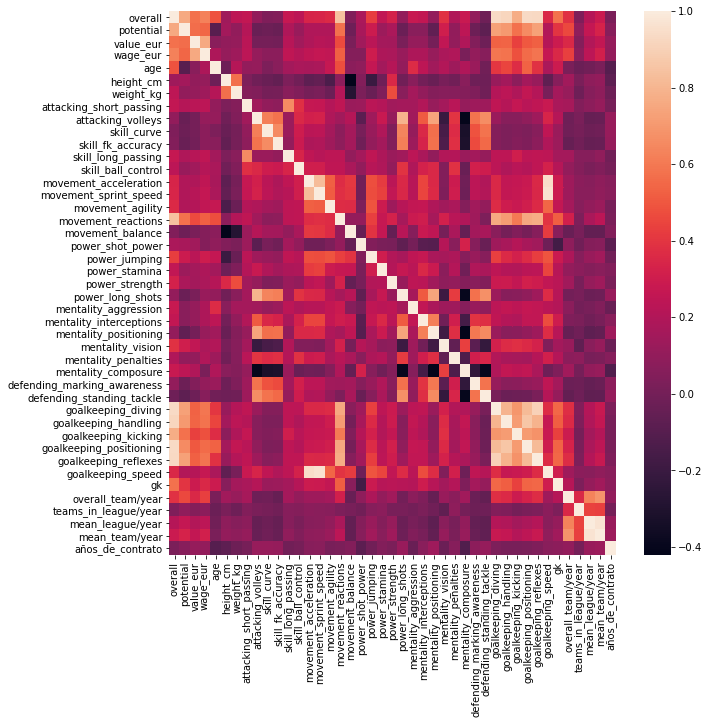

In [151]:
features=selected_feat.to_list()
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df[features].corr())

In [152]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [153]:

%%time
#vamos viendo y eliminando variable de forma iterativa
X = sm.add_constant(df[features].drop(['mean_team/year','goalkeeping_speed','goalkeeping_positioning','goalkeeping_reflexes',
                                      'goalkeeping_diving','goalkeeping_handling','potential'],axis=1))
VIF=pd.Series([variance_inflation_factor(X,i) for i in range (1, X.shape[1])],index=X.columns[1:]).sort_values(kind="quicksort",ascending=False)
VIF[1:].head()

Wall time: 1.15 s


movement_reactions       3.842984
power_long_shots         3.687897
mentality_positioning    3.584575
movement_acceleration    3.546220
movement_sprint_speed    3.517163
dtype: float64

In [154]:
variables_def=df[features].drop(['mean_team/year','goalkeeping_speed','goalkeeping_positioning','goalkeeping_reflexes',
                                      'goalkeeping_diving','goalkeeping_handling','potential'],axis=1).columns

In [155]:
#redefinimos X:
X=df[variables_def.to_list()]

<AxesSubplot:>

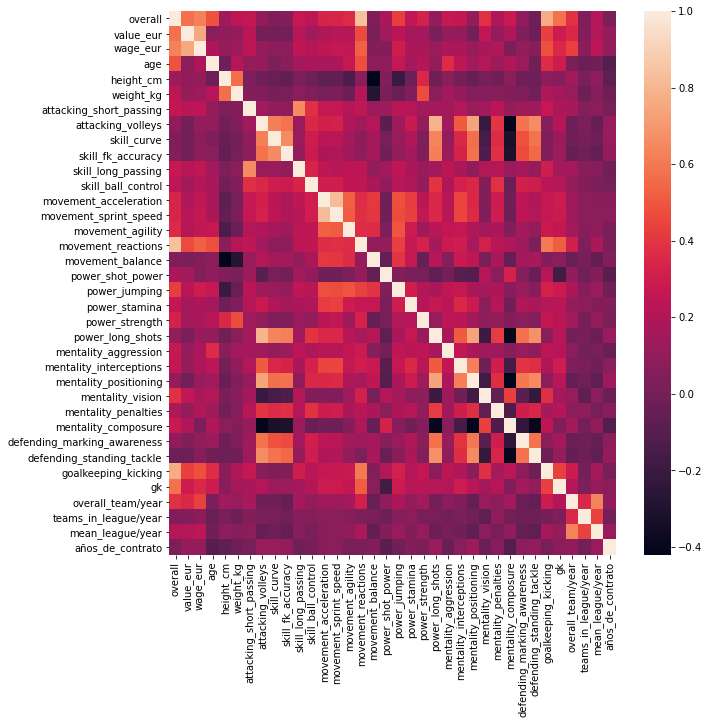

In [156]:
#volvemos a mirar correlación
features=selected_feat.to_list()
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(X.corr())

## Primer modelo naive

In [157]:
#split el dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [158]:
model=RandomForestClassifier()

In [159]:
model.fit(X_train,y_train)

RandomForestClassifier()

In [160]:
model.score(X_test,y_test)

0.9558899844317592

In [161]:
y_pred=model.predict(X_test)

In [162]:
print(classification_report(y_test,y_pred)) 
#Se observa accury muy alta => consecuencia posible de df muy desbalanceado

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1845
           1       0.00      0.00      0.00        82

    accuracy                           0.96      1927
   macro avg       0.48      0.50      0.49      1927
weighted avg       0.92      0.96      0.94      1927



In [163]:
#desbalanceo de X
1845/1927

0.9574468085106383

## Segundo modelo con undersampling

In [164]:
rus = RandomUnderSampler(random_state=0)
X_res, y_res =rus.fit_resample(X, y)

#split el dataframe
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)



In [165]:
model=RandomForestClassifier()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

print(classification_report(y_test, y_pred))
#random forest classifier consigue un 72% de accuracy

              precision    recall  f1-score   support

           0       0.69      0.69      0.69        80
           1       0.73      0.73      0.73        93

    accuracy                           0.71       173
   macro avg       0.71      0.71      0.71       173
weighted avg       0.71      0.71      0.71       173



In [166]:
model2=SVC()
model2.fit(X_train,y_train)
y_pred=model2.predict(X_test)
print(classification_report(y_test, y_pred))
#SVC consigue un 66% de accuracy

              precision    recall  f1-score   support

           0       0.72      0.42      0.54        80
           1       0.63      0.86      0.73        93

    accuracy                           0.66       173
   macro avg       0.68      0.64      0.63       173
weighted avg       0.68      0.66      0.64       173



## Tercer modelo con Over-sampling

In [167]:
#res= SMOTEN()
res = RandomOverSampler(random_state=0)

In [168]:
X_res,y_res=res.fit_resample(X, y)

In [169]:
#comprobación
sum(y_res)/len(y_res) 

0.5

In [170]:
#split el dataframe
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

In [171]:
model3=RandomForestClassifier()
model3.fit(X_train,y_train)
y_pred=model3.predict(X_test)
print(classification_report(y_test, y_pred))
#random forest classifier con oversampling consigue un 100% de accuracy

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1847
           1       0.99      1.00      1.00      1834

    accuracy                           1.00      3681
   macro avg       1.00      1.00      1.00      3681
weighted avg       1.00      1.00      1.00      3681



In [172]:
#no ejecuto porque el anterior ya me vale
'''model4=SVC()
model4.fit(X_train,y_train).score(X_test,y_test)
y_pred=model4.predict(X_test)
print(classification_report(y_test, y_pred))
#SVC con oversampling consigue un 77% de accuracy'''

'model4=SVC()\nmodel4.fit(X_train,y_train).score(X_test,y_test)\ny_pred=model4.predict(X_test)\nprint(classification_report(y_test, y_pred))\n#SVC con oversampling consigue un 77% de accuracy'

## Parameter tunnig

In [174]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [175]:
%%time
from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=model3, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

Wall time: 31min 30s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [176]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [177]:
model_def=RandomForestClassifier(max_features='sqrt', n_estimators= 500, max_depth=8, criterion='gini')
model_def.fit(X_train,y_train)
y_pred=model_def.predict(X_test)
print(classification_report(y_test, y_pred))
#random forest classifier con oversampling consigue un 90% de accuracy

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1847
           1       0.84      0.99      0.91      1834

    accuracy                           0.90      3681
   macro avg       0.92      0.90      0.90      3681
weighted avg       0.92      0.90      0.90      3681



## Exportar modelo

In [178]:
import pickle

In [179]:
#wb => de escritura y binario
with open('./models/model_GK.pkl','wb') as f:
    pickle.dump(model_def,f)

## Variables a usar

In [180]:
variables_def.to_list()

['overall',
 'value_eur',
 'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'goalkeeping_kicking',
 'gk',
 'overall_team/year',
 'teams_in_league/year',
 'mean_league/year',
 'años_de_contrato']